# Mobility in Tokyo

- Data source: NTT DoCoMo's [Mobile Kukan Toukei](https://mobaku.jp/)
    - “Mobile Kukan Toukei” is a trademark of NTT DOCOMO, INC.
    - NTT DOCOMO’s “Mobile Kukan Toukei” services are only available to subscribers in Japan.


In [107]:
# Load the row-based data and convert them into a time_pop_table
# Only new data up until yesterday will be processed and appended to the table file
# How to download files from S3
# $ aws s3 sync s3://mobaku-delivery-user002 .
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
%load_ext autotime

def read_time_pop_table(year):
    t = pd.read_csv("Data/DoCoMo/" + year + "_out2.csv", parse_dates=[0]) \
        .rename(columns={"Unnamed: 0": "Date_Time"}) \
        .set_index("Date_Time")
    return t

year = "2020"
time_pop_table_t = read_time_pop_table(year).T
# display(time_pop_table_t.head())
# print(time_pop_table_t.index)

last_date = time_pop_table_t.columns[-1]
print("last_date = ", last_date)
print(pd.Timestamp.today())
dates_to_add = pd.date_range(start=last_date.date()+pd.Timedelta('1 days'), end=pd.Timestamp.today()-pd.Timedelta('1 days'))

for d in dates_to_add:
    d_str = d.strftime("%Y%m%d")
    for h in range(24):
        f = "f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/{}/clipped_mesh_pop_{}{:02d}00_00000.csv.zip".format(d_str,d_str,h)
        print("Reading {}...".format(f))
        hourly = pd.read_csv(f,usecols=["area", "population"], dtype={"area": str})
        hourly = hourly.set_index("area")
        d_h = d + pd.Timedelta('{} hours'.format(h))
        hourly.rename(columns={"population": d_h}, inplace=True)
        # print(d_h)
        # display(hourly.head())
        # print(hourly.index)
        time_pop_table_t = time_pop_table_t.merge(hourly, how='left', left_index=True, right_index=True)
    
time_pop_table_t.T.to_csv("Data/DoCoMo/" + year + "_out2.csv")


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
last_date =  2020-04-15 23:00:00
2020-04-17 07:11:16.277149
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160000_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160100_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160200_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160300_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160400_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160500_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160600_00000.csv.zip...
Reading f:/Users/Hiroshi/Desktop/DoCoMo/s3/realtime/20200416/clipped_mesh_pop_202004160700_00000.csv

0.0

time: 2 ms


In [1]:
# Load the row-based data and convert them into a table

import pandas as pd
import matplotlib.pyplot as plt
import os
%load_ext autotime

year = "2020"
year = "2019"

def convert_to_table(year):
    fn = "data/DoCoMo/" + year + "_all.csv"
    if os.path.exists(fn):
        pass
    else:
        d = pd.read_csv(fn,usecols=[0,1,2,6],names=["Date", "Time", "Mesh", "Population"],
                        # dtype={"Mesh":str},
                        parse_dates=[[0,1]],header=None)

        print("{} loaded, n_records={}".format(fn, len(d)))
        start_time, end_time = d["Date_Time"].min(), d["Date_Time"].max()
        time_range = pd.date_range(start=start_time, end=end_time, freq='H')
        print("time_range=", time_range)
        mesh_list = d["Mesh"].unique()
        print("n_mesh=", len(mesh_list))
        print("mesh_list=", mesh_list)
        df = pd.DataFrame(index=time_range, columns=mesh_list)

        for i, row in d.iterrows():
            if i % 100000 == 0:
                print("{}: Processing record {}...".format(pd.Timestamp.now(), i))
            date_time = row[0]
            mesh = row[1]
            population = row[2]
            df.loc[date_time, mesh] = population

        df.to_csv("Data/DoCoMo/" + year + "_out2.csv")

# convert_to_table("2019")
# convert_to_table("2020")

In [108]:
# Load table data into DataFrame

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext autotime
default_figsize = plt.rcParams['figure.figsize']

def read_out2(year):
    df = pd.read_csv("Data/DoCoMo/" + year + "_out2.csv", parse_dates=[0])
    df = df.rename(columns={'Unnamed: 0':"Date_Time"}).set_index("Date_Time").fillna(0)
    l1_delta = np.zeros(len(df))
    l2_delta = np.zeros(len(df))
    mean = np.zeros(len(df))
    std = np.zeros(len(df))
    for i in range(1,len(df)):
        l1_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=1)
        l2_delta[i] = np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values, ord=2)
        mean[i] = df.iloc[i].mean()
        std[i] = df.iloc[i].std()
    df["L1"] = l1_delta
    df["L2"] = l2_delta
    df["mean"] = mean
    df["std"] = std
    return df

# mobility_2019 = read_out2("2019")
mobility_2020 = read_out2("2020")



The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 13.3 s


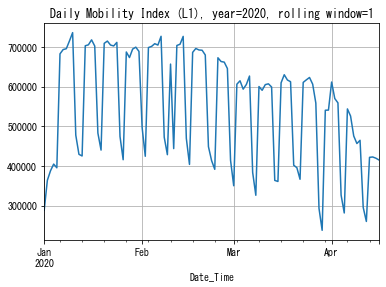

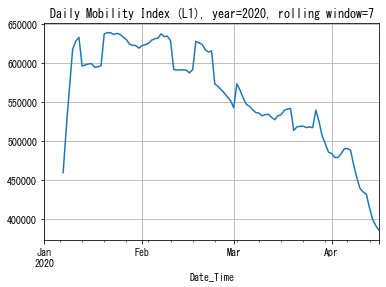

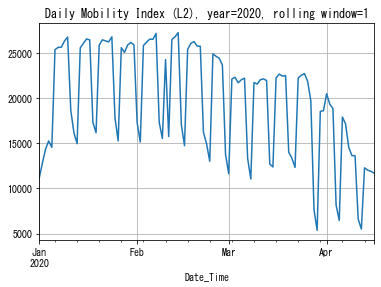

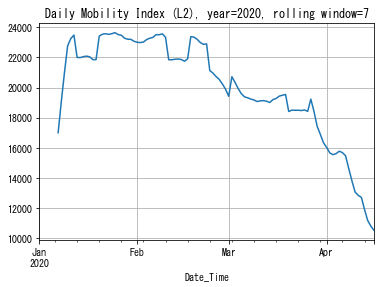

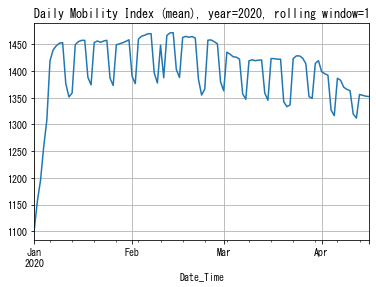

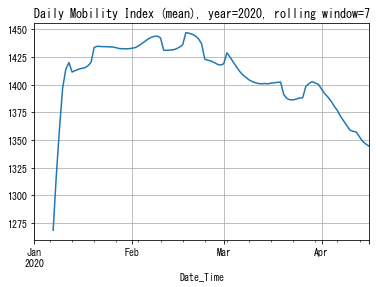

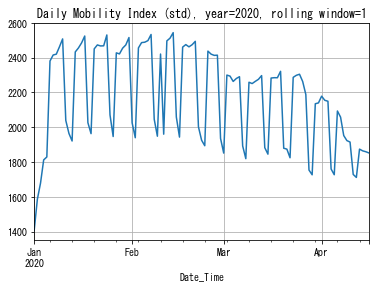

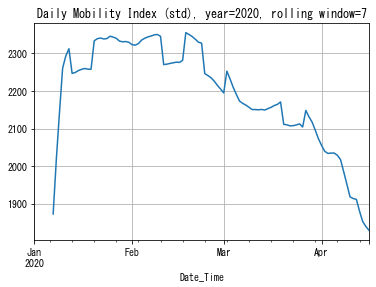

time: 1.33 s


In [109]:
# plot various mobility indicators 

def mobility_plot(df, metric, year, w):
    mobility = df[metric]
    daily_mobility = mobility.resample('1D').mean().rolling(w).mean()
    plt.title("Daily Mobility Index ({}), year={}, rolling window={}".format(metric, year,w))
    daily_mobility.plot(grid=True)
    plt.show()


# mobility_plot(mobility_2020.loc[pd.to_datetime("2020-02-01"):], "L1", "2020", 7)
    
#mobility_plot(mobility_2019, "L1", "2019", 1)
#mobility_plot(mobility_2019, "L1", "2019", 7)
mobility_plot(mobility_2020, "L1", "2020", 1)
mobility_plot(mobility_2020, "L1", "2020", 7)

#mobility_plot(mobility_2019, "L2", "2019", 1)
#mobility_plot(mobility_2019, "L2", "2019", 7)
mobility_plot(mobility_2020, "L2", "2020", 1)
mobility_plot(mobility_2020, "L2", "2020", 7)

#mobility_plot(mobility_2019, "mean", "2019", 1)
#mobility_plot(mobility_2019, "mean", "2019", 7)
mobility_plot(mobility_2020, "mean", "2020", 1)
mobility_plot(mobility_2020, "mean", "2020", 7)

#mobility_plot(mobility_2019, "std", "2019", 1)
#mobility_plot(mobility_2019, "std", "2019", 7)
mobility_plot(mobility_2020, "std", "2020", 1)
mobility_plot(mobility_2020, "std", "2020", 7)



## Confirmed Cases in Tokyo
- Data source: [Tokyo Metropolitan Governmnet Open Data Catalogue Site](https://portal.data.metro.tokyo.lg.jp/) [Dashboard](https://stopcovid19.metro.tokyo.lg.jp/)

Days in daily_confirmed_cases= 47


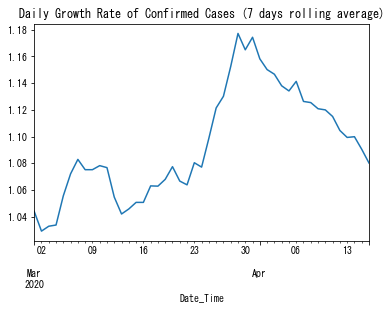

time: 1.88 s


In [110]:
# Load confirmed cases

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)

daily_confirmed_cases = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv',
                    usecols=["公表_年月日", "患者_年代", "患者_性別"],
                    parse_dates=["公表_年月日"]) \
    .groupby("公表_年月日") \
    .count().drop(columns=["患者_年代"]) \
    .reset_index() \
    .rename(columns={"患者_性別": "Confirmed_Cases", "公表_年月日": "Date_Time"}) \
    .set_index("Date_Time")

daily_confirmed_cases = daily_confirmed_cases.asfreq('1D', fill_value=0)

# display(daily_confirmed_cases.asfreq('1D', fill_value=0))

window = 7
# plt.grid()
daily_confirmed_cases["Cumulative"] = daily_confirmed_cases["Confirmed_Cases"].cumsum()
daily_confirmed_cases["GrowthRate"] = daily_confirmed_cases["Cumulative"].pct_change().rolling(window).mean()
daily_confirmed_cases = daily_confirmed_cases["2020-03-01":]
days = len(daily_confirmed_cases)
print("Days in daily_confirmed_cases=", len(daily_confirmed_cases))

plt.title("Daily Growth Rate of Confirmed Cases ({} days rolling average)".format(window)) 
(daily_confirmed_cases["GrowthRate"] + 1.0).plot()

last date in mobility = 2020-04-16 00:00:00
last date confirmed = 2020-04-16 00:00:00
first date confirmed = 2020-03-01 00:00:00
min_delay =  0
days in confirmed_cases = 46 days 00:00:00
0 2020-03-01 00:00:00 2020-04-16 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


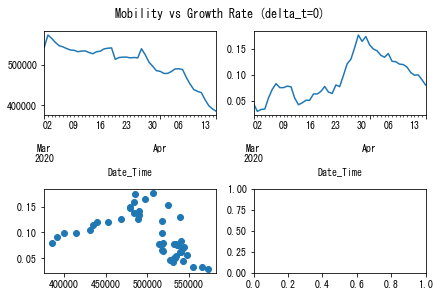

1 2020-02-29 00:00:00 2020-04-15 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


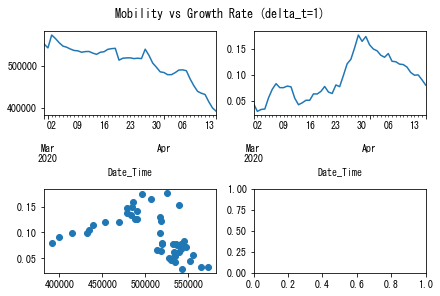

2 2020-02-28 00:00:00 2020-04-14 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


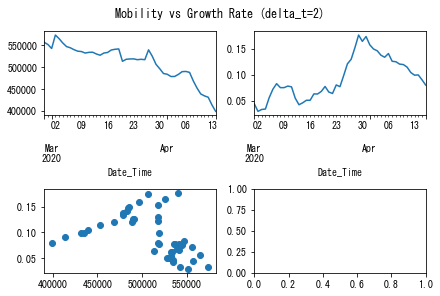

3 2020-02-27 00:00:00 2020-04-13 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


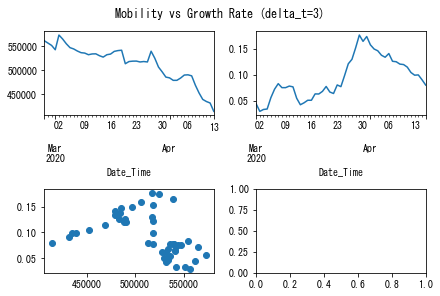

4 2020-02-26 00:00:00 2020-04-12 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


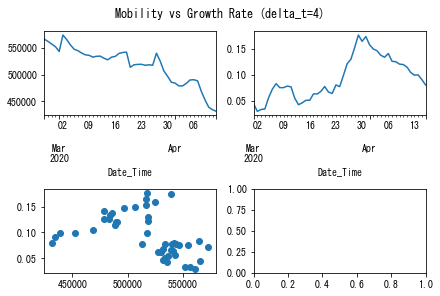

5 2020-02-25 00:00:00 2020-04-11 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


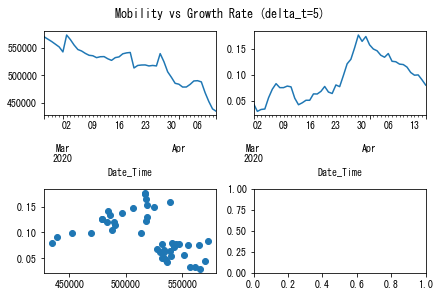

6 2020-02-24 00:00:00 2020-04-10 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


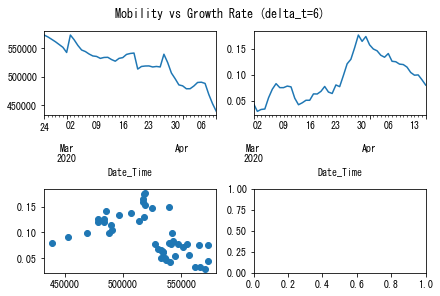

7 2020-02-23 00:00:00 2020-04-09 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


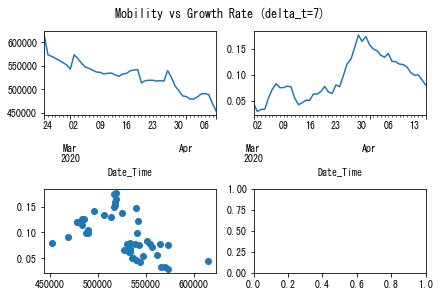

8 2020-02-22 00:00:00 2020-04-08 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


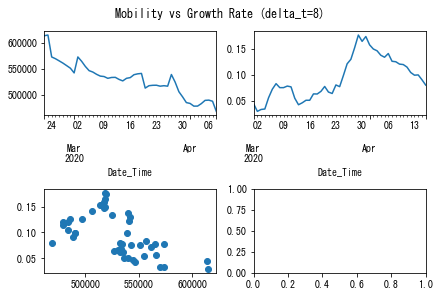

9 2020-02-21 00:00:00 2020-04-07 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


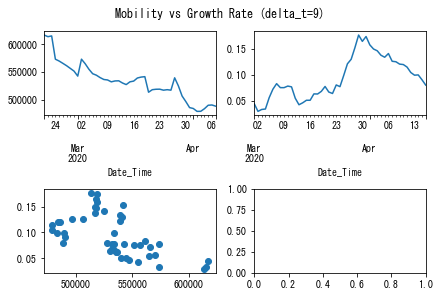

10 2020-02-20 00:00:00 2020-04-06 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


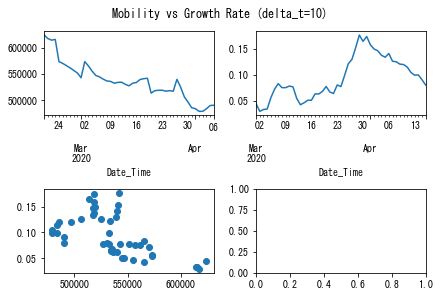

11 2020-02-19 00:00:00 2020-04-05 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


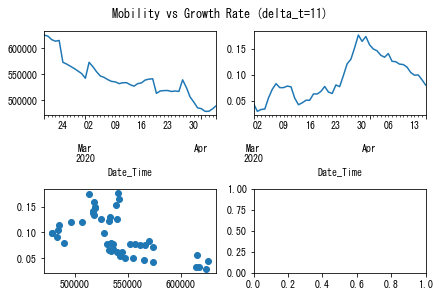

12 2020-02-18 00:00:00 2020-04-04 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


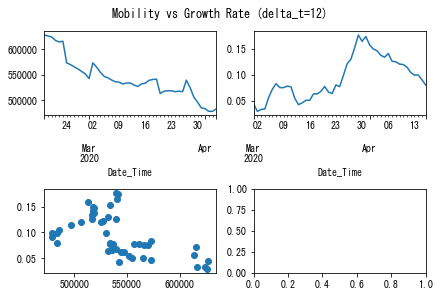

13 2020-02-17 00:00:00 2020-04-03 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


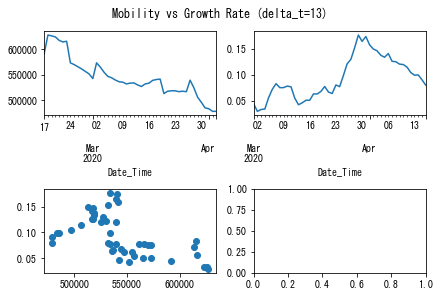

14 2020-02-16 00:00:00 2020-04-02 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


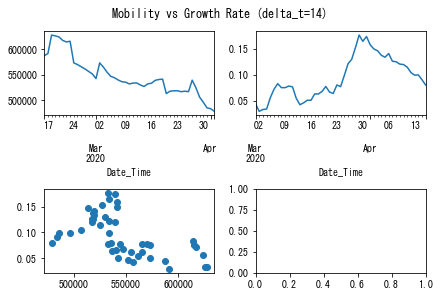

15 2020-02-15 00:00:00 2020-04-01 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


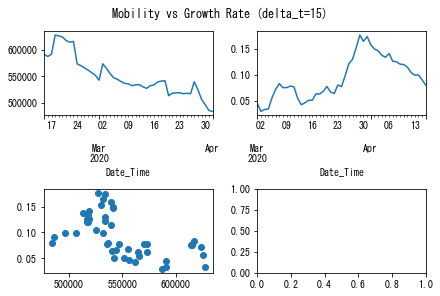

16 2020-02-14 00:00:00 2020-03-31 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


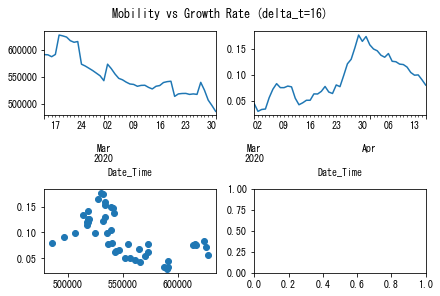

17 2020-02-13 00:00:00 2020-03-30 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


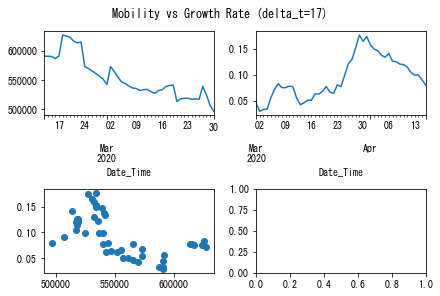

18 2020-02-12 00:00:00 2020-03-29 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


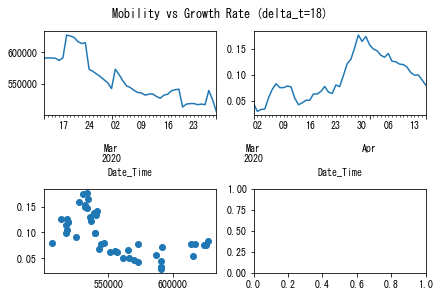

19 2020-02-11 00:00:00 2020-03-28 00:00:00 2020-03-01 00:00:00 2020-04-16 00:00:00 (47,) (47,)


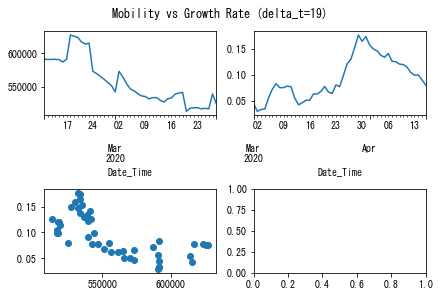

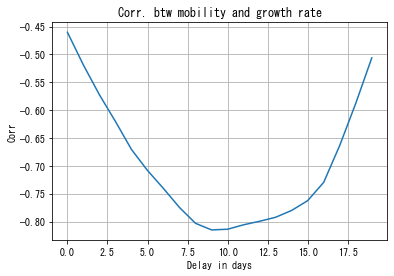

time: 20.3 s


In [111]:
# Caculate correlations between mobility and growth rate of confirmed cases

import datetime 

daily_mobility = mobility_2020.resample('1D').mean().rolling(7).mean()
# display(daily_confirmed_cases)

last_date_mobility = daily_mobility.index[-1]
last_date_confirmed = daily_confirmed_cases.index[-1]
first_date_confirmed = daily_confirmed_cases.index[0]
min_delay = last_date_confirmed - last_date_mobility
days_in_confirmed_cases = last_date_confirmed - first_date_confirmed
print("last date in mobility =",last_date_mobility)
print("last date confirmed =", last_date_confirmed )
print("first date confirmed =", first_date_confirmed )
print("min_delay = ", min_delay.days)
print("days in confirmed_cases =", days_in_confirmed_cases)

w = 20 # max delta t
corr = np.zeros(w)
for delta_t in range(min_delay.days, w):
    s0 = first_date_confirmed - datetime.timedelta(days=delta_t)
    e0 = s0 + days_in_confirmed_cases
    m = daily_mobility["L1"][s0:e0]
    s1 = s0 + datetime.timedelta(days=delta_t)
    e1 = e0 + datetime.timedelta(days=delta_t)
    g = daily_confirmed_cases["GrowthRate"][s1:e1]
    print(delta_t, s0, e0, s1, e1, m.shape, g.shape)
    corr[delta_t] = m.corr(g)
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.suptitle("Mobility vs Growth Rate (delta_t={})".format(delta_t))
    m.plot(ax=axs[0, 0])
    g.plot(ax=axs[0, 1])
    axs[1, 0].scatter(m, g)
    plt.show()
    # print(d, len(n_calls), len(n_reported), corr[d])

plt.grid()
plt.title("Corr. btw mobility and growth rate")
plt.xlabel("Delay in days")
plt.ylabel("Corr")
plt.plot(np.array(range(min_delay.days, w)), corr[min_delay.days:w])

(28,) (23,)


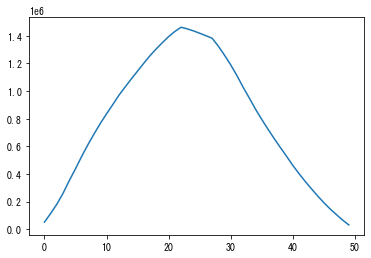

time: 153 ms


In [113]:
import sklearn
m = daily_mobility["L1"]["2020-03-20":"2020-04-16"]
g = daily_confirmed_cases["GrowthRate"]["2020-03-25":"2020-04-16"]
print(m.shape, g.shape)
plt.plot(np.convolve(g, m))

# Statistics on Mobility Data


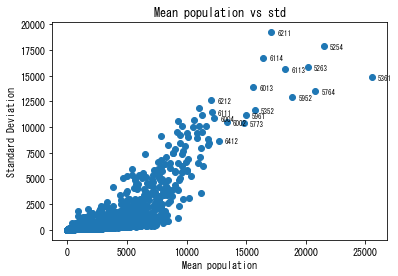

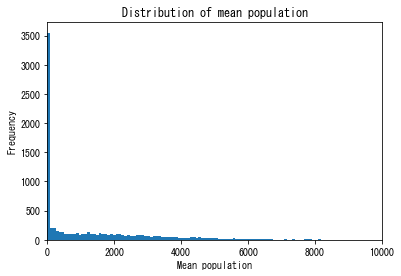

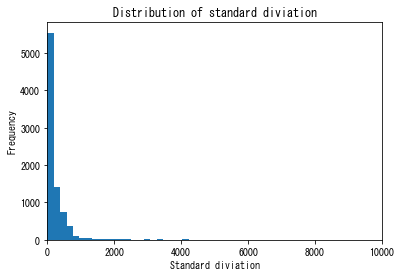

Large mean grids
533945361    25558.302570
533945254    21509.647196
533945764    20817.866044
533945263    20202.270639
533935952    18898.670171
533946113    18302.866044
533946211    17124.191978
533946114    16441.459112
533945352    15723.477414
533946013    15620.863707
533935961    14994.649533
533945773    14824.282321
533946002    13412.674065
533946412    12689.773754
533946004    12343.848910
533946111    12134.772586
533946212    12077.374221
533946314    11915.640576
533946312    11823.368380
533945351    11804.370327
533946011    11676.813474
533935764    11356.489097
533946001    11303.149922
533935591    11270.435358
533945363    11250.681464
533935863    11191.433022
533935854    11095.738707
533946214    11072.769860
533946213    11009.364875
533945771    11001.478583
533945253    10916.714953
533936903    10878.843069
533946112    10636.447819
533945093    10563.185358
533943333    10408.732866
533945362    10219.676791
533935794    10121.603972
533946311    10088.09

Index(['533935952', '533935961', '533945254', '533945263', '533945352',
       '533945361', '533945764', '533945773', '533946002', '533946004',
       '533946013', '533946111', '533946113', '533946114', '533946211',
       '533946212', '533946412'],
      dtype='object')

time: 1.39 s


In [114]:
mean = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).std()



plt.title("Mean population vs std")
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std)
large_mean = mean[mean>12000]
for mesh in large_mean.index:
    plt.text(mean[mesh]+500, std[mesh]-300, str(mesh)[-4:], fontsize=7 )

plt.show()

plt.title("Distribution of mean population")
plt.xlabel("Mean population")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(mean, bins=300)
# plt.plot(mean.cumsum())
plt.show()

plt.title("Distribution of standard diviation")
plt.xlabel("Standard diviation")
plt.ylabel("Frequency")
plt.xlim((0, 10000))
plt.hist(std, bins=100)
plt.show()

mobility_2020
print("Large mean grids")
print(mean[mean>10000].sort_values(ascending=False))
print("Large std grids")
print(std[std>15000].sort_values(ascending=False))

large_mean.index

- 平均人口が最も多いのは歌舞伎町 The largest mean populatioin is at Kabuki-cho (533945361    27699.655220)
- 標準偏差が最も大きいのは大手町 The largest standard diviation is at Otemachi（533946211    20066.947698）

You can check the location of a meshcode at [Geocode Viewer](http://www.geosense.co.jp/map/tool/geoconverter.php) 

まあ、そうだろう、という感じ The results are no surprise.

533945361 歌舞伎町 25706.637971698114 14838.065888188736
533946211 大手町 17198.595911949684 19297.445899783008
533934771 成城学園前 1635.7425314465409 229.7606872394541
533935431 八雲 3842.489386792453 583.0433092637022


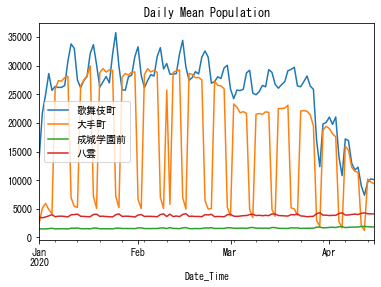

time: 250 ms


In [103]:
# Plot daily mean population for selected grid cells

focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
to_plot = mobility_2020[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .resample('1D').mean()

to_plot .plot()
plt.title("Daily Mean Population")
to_plot.std()
for key in focused_grids:
    print(key,focused_grids[key], mean[key], std[key] )


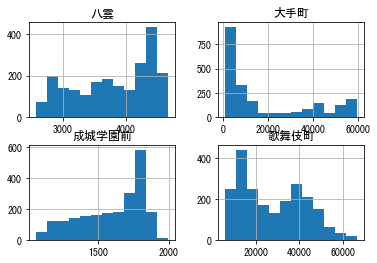

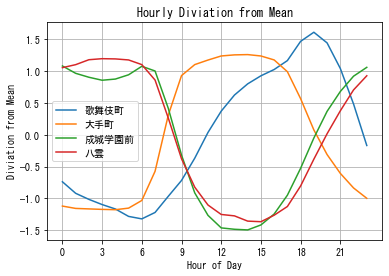

Index(['歌舞伎町', '大手町', '成城学園前', '八雲'], dtype='object')

time: 1.66 s


In [9]:
# Other statistics for selected grid cells

from sklearn import preprocessing

focused_grids = {'533945361':"歌舞伎町", '533946211':"大手町",
                '533934771':"成城学園前", '533935431':"八雲"}
# focused_grids = {'533945361':"歌舞伎町",'533946211':"大手町", '533945363': "荏原" }
# 歌舞伎町と大手町の人口ヒストグラム
mobility_2020[list(focused_grids.keys())] \
    .rename(columns=focused_grids) \
    .hist(bins=12)
plt.show()

hour_of_day = mobility_2020.groupby(mobility_2020.index.hour).mean()
hour_of_day = hour_of_day[list(focused_grids.keys())] \
    .rename(columns=focused_grids)


h = preprocessing.scale(hour_of_day)
for i in range(len(hour_of_day.columns)):
    plt.plot(range(24),h[:, i],label=hour_of_day.columns[i])
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 24, step=3))
plt.title("Hourly Diviation from Mean")
plt.xlabel("Hour of Day")
plt.ylabel("Diviation from Mean")
plt.show()
hour_of_day.columns

## Correlation with onset dates

- Data source:  [Jag Japan](https://gis.jag-japan.com/covid19jp/)

Unfortunately the data has no onset date for recent Tokyo cases.

last_date= 2020-04-15 00:00:00 n_records= 8520
2446


受診都道府県    217
dtype: int64

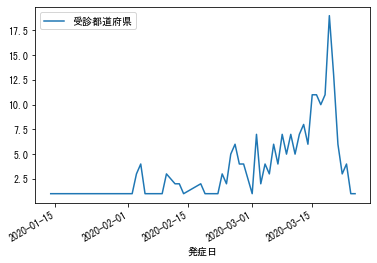

time: 1.73 s


In [10]:
# Correlation with onset dates

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'family' : 'MS Gothic'}
mpl.rc('font', **font)
fn = 'https://dl.dropboxusercontent.com/s/6mztoeb6xf78g5w/COVID-19.csv'
# fn = 'data/JAG_Japan/COVID-19.csv'

def read_data():
    d = pd.read_csv(fn,usecols=["確定日", "発症日", "受診都道府県"],parse_dates=["確定日", "発症日"])
    d = d.drop(["不明", "中部国際空港", "成田空港", "羽田空港", "関西国際空港"], errors='ignore')
    return d


jag_report = read_data()
last_date = jag_report["確定日"].max()
print("last_date=", last_date, "n_records=", len(jag_report))
jag_report = jag_report.drop(columns=["確定日"])
print(len(jag_report[jag_report["受診都道府県"]=="東京都"]))
onset = jag_report[jag_report["受診都道府県"]=="東京都"].groupby("発症日").count()
onset.plot()
onset.sum()

発症日のデータを取ってみたが、東京都の症例では、最近は発症日が記入されていない。このため、よい相関が取れない。あきらめ。


In [11]:
# Experimantal code. Please ignore
if 0: 

    fig, ax1 = plt.subplots()

    # ヒストグラムプロットとビン情報の取得
    n, bins, patches = ax1.hist(mean, alpha=0.7, label='Frequency', bins=20)
    ax1.grid(axis='x')
    ax1.set_xlabel("Grid Population")
    ax1.set_ylabel("Frequency")

    # 第2軸用値の算出
    y2 = np.add.accumulate(n) / n.sum()
    x2 = np.convolve(bins, np.ones(2) / 2, mode="same")[1:]

    # 第2軸のプロット
    ax2 = ax1.twinx()
    lines = ax2.plot(x2, y2, ls='--', color='r', marker='o',
             label='Cumulative ratio')
    ax2.grid(visible=True)
    ax2.set_ylabel("Cumulative %")

    plt.show()

time: 1 ms


In [12]:
# Experimantal code. Please ignore

if 0: 
    ranked_means = mean.sort_values(ascending=False)
    # print(ranked_means)
    total = ranked_means.sum()
    print("sum=", total)
    top_n = 100

    fig, ax1 = plt.subplots()
    ax1.plot(np.arange(top_n), ranked_means[:top_n])
    ax2 = ax1.twinx()
    ax2.plot(ranked_means[:top_n].cumsum() / total)
    plt.show()

time: 6.97 ms


In [13]:
# Experimantal code. Please ignore

if 0: 
    # 平成25年住宅・土地統計調査 確報集計
    print(pd.__version__)
    fn = 'data/estat/FEH_00200522_200408215652.csv'

    def read_data():
        d = pd.read_csv(fn, skiprows=14, sep=',', usecols=["H25地域", "世帯の年間収入階級_2013", "総数" ], 
                        thousands=',', encoding="SHIFT-JIS")
        d["総数"] = d["総数"].str.replace(',', '')
        d["総数"] = d["総数"].str.replace('-', '0')  #  '-' はゼロと解釈
        d["総数"] = d["総数"].astype(int)
        return d

    rank = [0, 100, 200, 300, 400, 500, 700, 1000, 1500]
    # rank = [50, 150, 250, 350, 450, 600, 850, 1250, 1500]

    def median(total, counts):
        # print("total=", total, "counts=", counts)
        h = total / 2
        c = 0
        for i in range(len(counts)):
            c += counts.values[i]
            if c > h:
                return rank[i]
        return None

    household_income = read_data()
    # print(household_income["総数"])
    n_records = len(household_income)
    meds = np.zeros(n_records)
    for i in range(0, n_records, 10):
    # for i in range(0, 1, 10):
        # print(household_income.iloc[i]["H25地域"])
        m = median(household_income.iloc[i]["総数"], household_income.iloc[i+1:i+10]["総数"])
        meds[i] = m

    household_income["Median"] = meds

    household_income


time: 3.98 ms


## Research Question: Which areas show larger mobility changes due to COVID-19?

1. Cluster grid cells
- Define mobility reduction
    - Take two time points, $t_1$ and $t_2$, and compute the mobility difference $\Delta = d(m(t_1), m(t_2))$
    - Let's take three Tuesdays, $t_0=$ Feb 4 (before Diamond Princess), $t_1$ = Mar 3 (after school closure), and $t_2=$ Mar 31 (lockdown imminent).
    - Calculate $\Delta = d(m(t_0), m(t_1))$ and $\Delta = d(m(t_0), m(t_2))$ for every cell

Using saved cluster data/DoCoMo/cluster.txt


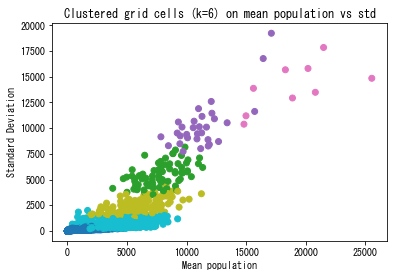

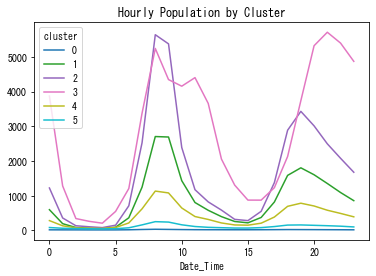

time: 1.33 s


In [118]:
# Cluster grid cells

from sklearn.cluster import KMeans
from matplotlib import colors as mcolors
import os

mobility_2020_L1 = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).diff().abs()
mobility_2020_L1_daily = mobility_2020_L1.groupby(mobility_2020_L1.index.hour).mean()

# If already clustered, use them
n_clusters = 6
cluster_fn = 'data/DoCoMo/cluster.txt'
if os.path.exists(cluster_fn):
    pred = np.loadtxt(cluster_fn)
    print('Using saved cluster', cluster_fn)
else:
    pred = KMeans(n_clusters=n_clusters).fit_predict(mobility_2020_L1_daily.values.T)
    np.savetxt('data/DoCoMo/cluster.txt',pred)


mean = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).mean()
std = mobility_2020.drop(columns=["L1", "L2", "mean", "std"]).std()

cmap = plt.get_cmap("tab10")

# Scatter Plot between mean and std
plt.title("Clustered grid cells (k={}) on mean population vs std".format(n_clusters))
plt.xlabel("Mean population")
plt.ylabel("Standard Deviation")
plt.scatter(mean, std, c=pred, cmap=cmap)
mobility_2020_L1_daily_t = mobility_2020_L1_daily.T
mobility_2020_L1_daily_t["cluster"] = pred.astype(int)

# Hourly population by Cluster
title = "Hourly Population by Cluster"
mobility_2020_L1_daily_t.groupby("cluster").mean().T.plot(title=title, cmap=cmap)
plt.show()

clustered_cells = mobility_2020_L1_daily_t["cluster"]
clustered_cells_df = pd.DataFrame(clustered_cells).reset_index().rename(columns={"index": "meshcode"})


## Plot results on map
- This code is by Kunihiko Miyoshi (https://github.com/colspan)

- Data source: 
    - 国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
    - 国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html
    - GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


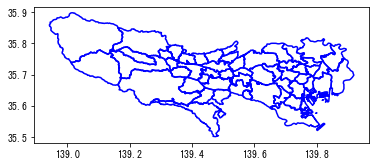

time: 4.24 s


In [15]:
# This code is by Kunihiko Miyoshi (https://github.com/colspan)
import csv
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime

%matplotlib inline
%load_ext autotime

pref_name_def = {
    "01": {
        "name_jp": "北海道",
        "name_en": "Hokkaido"
    },
    "02": {
        "name_jp": "青森県",
        "name_en": "Aomori"
    },
    "03": {
        "name_jp": "岩手県",
        "name_en": "Iwate"
    },
    "04": {
        "name_jp": "宮城県",
        "name_en": "Miyagi"
    },
    "05": {
        "name_jp": "秋田県",
        "name_en": "Akita"
    },
    "06": {
        "name_jp": "山形県",
        "name_en": "Yamagata"
    },
    "07": {
        "name_jp": "福島県",
        "name_en": "Fukushima"
    },
    "08": {
        "name_jp": "茨城県",
        "name_en": "Ibaraki"
    },
    "09": {
        "name_jp": "栃木県",
        "name_en": "Tochigi"
    },
    "10": {
        "name_jp": "群馬県",
        "name_en": "Gunma"
    },
    "11": {
        "name_jp": "埼玉県",
        "name_en": "Saitama"
    },
    "12": {
        "name_jp": "千葉県",
        "name_en": "Chiba"
    },
    "13": {
        "name_jp": "東京都",
        "name_en": "Tokyo"
    },
    "14": {
        "name_jp": "神奈川県",
        "name_en": "Kanagawa"
    },
    "15": {
        "name_jp": "新潟県",
        "name_en": "Niigata"
    },
    "16": {
        "name_jp": "富山県",
        "name_en": "Toyama"
    },
    "17": {
        "name_jp": "石川県",
        "name_en": "Ishikawa"
    },
    "18": {
        "name_jp": "福井県",
        "name_en": "Fukui"
    },
    "19": {
        "name_jp": "山梨県",
        "name_en": "Yamanashi"
    },
    "20": {
        "name_jp": "長野県",
        "name_en": "Nagano"
    },
    "21": {
        "name_jp": "岐阜県",
        "name_en": "Gifu"
    },
    "22": {
        "name_jp": "静岡県",
        "name_en": "Shizuoka"
    },
    "23": {
        "name_jp": "愛知県",
        "name_en": "Aichi"
    },
    "24": {
        "name_jp": "三重県",
        "name_en": "Mie"
    },
    "25": {
        "name_jp": "滋賀県",
        "name_en": "Shiga"
    },
    "26": {
        "name_jp": "京都府",
        "name_en": "Kyoto"
    },
    "27": {
        "name_jp": "大阪府",
        "name_en": "Osaka"
    },
    "28": {
        "name_jp": "兵庫県",
        "name_en": "Hyogo"
    },
    "29": {
        "name_jp": "奈良県",
        "name_en": "Nara"
    },
    "30": {
        "name_jp": "和歌山県",
        "name_en": "Wakayama"
    },
    "31": {
        "name_jp": "鳥取県",
        "name_en": "Tottori"
    },
    "32": {
        "name_jp": "島根県",
        "name_en": "Shimane"
    },
    "33": {
        "name_jp": "岡山県",
        "name_en": "Okayama"
    },
    "34": {
        "name_jp": "広島県",
        "name_en": "Hiroshima"
    },
    "35": {
        "name_jp": "山口県",
        "name_en": "Yamaguchi"
    },
    "36": {
        "name_jp": "徳島県",
        "name_en": "Tokushima"
    },
    "37": {
        "name_jp": "香川県",
        "name_en": "Kagawa"
    },
    "38": {
        "name_jp": "愛媛県",
        "name_en": "Ehime"
    },
    "39": {
        "name_jp": "高知県",
        "name_en": "Kochi"
    },
    "40": {
        "name_jp": "福岡県",
        "name_en": "Fukuoka"
    },
    "41": {
        "name_jp": "佐賀県",
        "name_en": "Saga"
    },
    "42": {
        "name_jp": "長崎県",
        "name_en": "Nagasaki"
    },
    "43": {
        "name_jp": "熊本県",
        "name_en": "Kumamoto"
    },
    "44": {
        "name_jp": "大分県",
        "name_en": "Oita"
    },
    "45": {
        "name_jp": "宮崎県",
        "name_en": "Miyazaki"
    },
    "46": {
        "name_jp": "鹿児島県",
        "name_en": "Kagoshima"
    },
    "47": {
        "name_jp": "沖縄県",
        "name_en": "Okinawa"
    },
}

# define functions

def meshcode_to_latlng(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = float((int(meshcode[8])-1) // 2) * 1.0/8.0/10.0/2.0/1.5
        half_lon = float((int(meshcode[8])-1) % 2) * 1.0/8.0/10.0/2.0
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = float(meshcode[0:2])/1.5 + float(meshcode[4]) * \
        1.0/8.0/1.5 + float(meshcode[6])*1.0/8.0/10.0/1.5 + half_lat
    longtitude = float(meshcode[2:4])+100.0 + float(meshcode[5]) * \
        1.0/8.0 + float(meshcode[7])*1.0/8.0/10.0 + half_lon
    return (latitude, longtitude)


def meshcode_to_latlng_index(meshcode):
    if len(meshcode) == 9:
        # 1/2メッシュコード
        half_lat = (int(meshcode[8])-1) // 2
        half_lon = (int(meshcode[8])-1) % 2
    else:
        # 3次メッシュコード
        half_lat = 0
        half_lon = 0
    latitude = int(meshcode[0:2])*8*10*2 + int(meshcode[4]
                                               )*10*2 + int(meshcode[6])*2 + half_lat
    longtitude = int(meshcode[2:4])*8*10*2 + \
        int(meshcode[5])*10*2 + int(meshcode[7])*2 + half_lon
    return (latitude, longtitude)

def llindex_to_latlng(lli):
    return (
        float(lli[0]) / 2 / 8 / 10 / 1.5,
        float(lli[1]) / 2 / 8 / 10 + 100)

def meshcode_to_polygon(meshcode):
    south_west_i = meshcode_to_latlng_index(meshcode)

    lat_i, lon_i = south_west_i
    diff = 1 if len(meshcode) == 9 else 2
    north_east_i = (lat_i + diff, lon_i + diff)
    sw_geo = llindex_to_latlng(south_west_i)
    ne_geo = llindex_to_latlng(north_east_i)

    coordinates = [
        [sw_geo[1], sw_geo[0]],
        [sw_geo[1], ne_geo[0]],
        [ne_geo[1], ne_geo[0]],
        [ne_geo[1], sw_geo[0]],
        [ne_geo[1], sw_geo[0]]
    ]
    return coordinates

df_tokyo = gpd.read_file('data/JapanCityGeoJason/13_tokyo.json')
# 重複を除外する
df_tokyo = df_tokyo[df_tokyo['id']!='13']
# 諸島を除外する
df_tokyo = df_tokyo[df_tokyo['id'].apply(lambda x: int(x)<13361)]

# 注意 : このデータを利用するには下記クレジットが必要
'''
国土数値情報 (JPGIS2.1(GML)準拠及びSHAPE形式データ)　国土交通省
国土交通省国土政策局GISHP http://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03.html

GeoJSON生成 : https://github.com/niiyz/JapanCityGeoJson
'''
# 地図を描画
ax = df_tokyo.boundary.plot(color='blue')



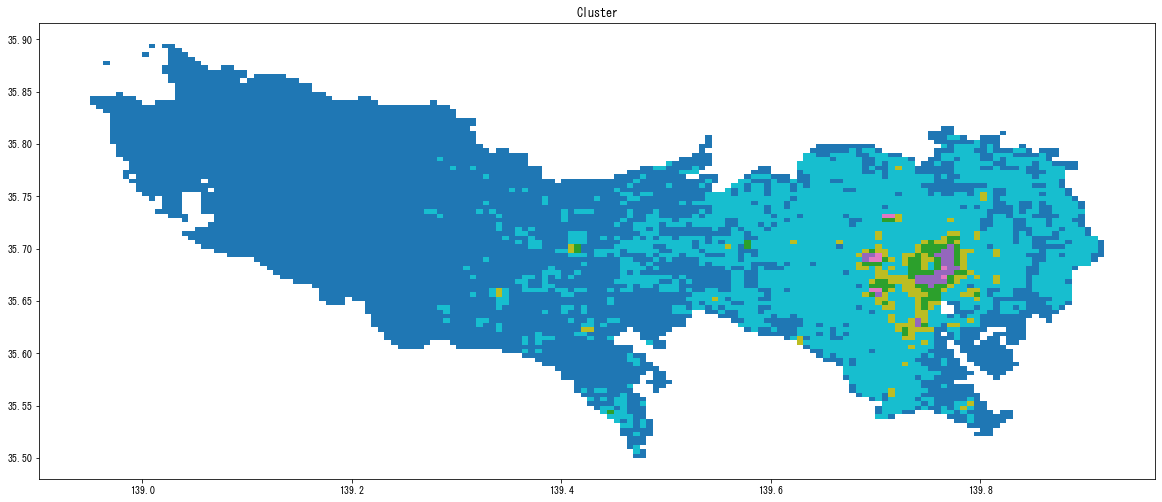

time: 1.47 s


In [16]:
from shapely.geometry import Polygon
# figsize_save = plt.rcParams['figure.figsize']
def show_cells_on_map(df, column, cmap=cmap, title=None, legend=False, legend_kwds=None):
    # df should have "meshcode" for meshcode and column for the data to be displayed
    plt.rcParams['figure.figsize'] = (20, 10)
    # 島しょ部を除外する
    df_poplog_geo = df[df.meshcode > '530000000']
    df_poplog_geo = gpd.GeoDataFrame(df_poplog_geo)

    # meshcodeに対応するポリゴンを生成する
    df_poplog_geo['geometry'] = df_poplog_geo['meshcode'].apply(lambda x: Polygon(meshcode_to_polygon(x)))  

    ax = df_poplog_geo.plot(column=column, cmap=cmap, legend=legend, legend_kwds=legend_kwds)
    plt.title(title)
    plt.rcParams['figure.figsize'] = default_figsize
    
show_cells_on_map(clustered_cells_df, 'cluster', title="Cluster")

cluster,0,1,2,3,4,5
2020-03-03,-0.054174,-0.104414,-0.095704,-0.137727,-0.125639,-0.115141
2020-03-31,-0.116000,-0.261902,-0.264403,-0.351652,-0.279356,-0.235687
2020-04-16,-0.027052,-0.562691,-0.577743,-0.657435,-0.530366,-0.393816


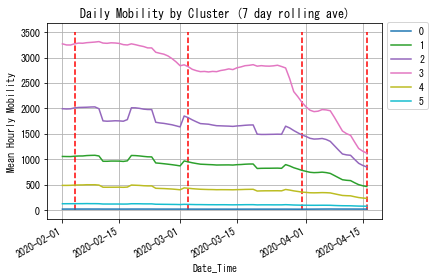

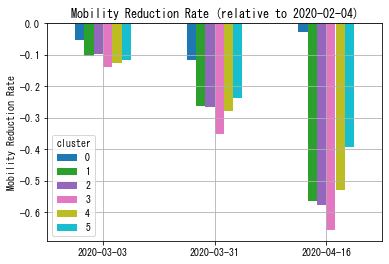

count    8519.000000
mean        3.675957
std         0.666302
min         0.000000
25%         3.307453
50%         3.434755
75%         3.980794
max         7.851471
Name: reduction, dtype: float64


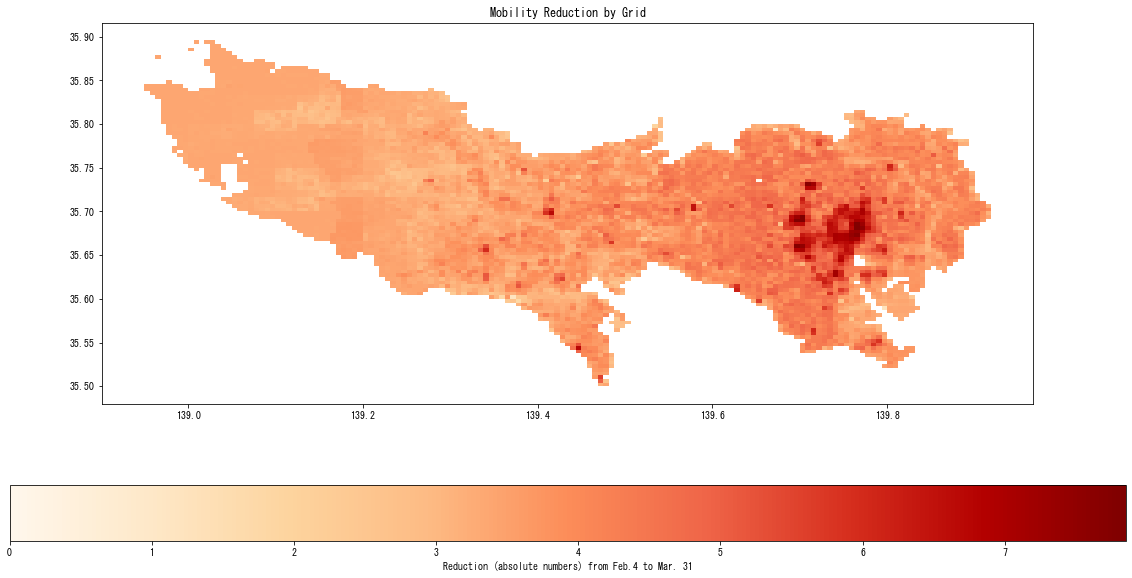

time: 2.68 s


In [179]:
# Mobility Time Series by Cluster
window = 7
reference_dates = pd.to_datetime(['2020-02-04', '2020-03-03', '2020-03-31', '2020-04-16'])

mobility_by_cells = mobility_2020_L1.resample('1D').mean().rolling(window).mean().loc['2020-2-1':].T
m = mobility_by_cells.copy()
m["cluster"] = pred.astype(int)
title = "Daily Mobility by Cluster ({} day rolling ave)".format(window)
mobility_by_cluster = m.groupby("cluster").mean().T
# print(mobility_by_cluster.shift(- (window // 2)))
# mobility_by_cluster.shift(- (window // 2)).plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
mobility_by_cluster.plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
plt.ylabel("Mean Hourly Mobility")
plt.vlines(reference_dates, 0, 3500, "red", linestyles='dashed')

# mobility reduction rate by cluster
m = mobility_by_cluster.T.loc[:,reference_dates]
for t in range(1, len(reference_dates)):
    m[reference_dates[t]] =  m[reference_dates[t]] / m[reference_dates[0]] - 1.0

display(m.drop(columns=reference_dates[0]).T)
m.drop(columns=reference_dates[0]).T.plot.bar(cmap=cmap, grid=True)
plt.title("Mobility Reduction Rate (relative to {})".format(reference_dates[0].date()))
plt.ylabel("Mobility Reduction Rate")
plt.xticks(range(len(reference_dates[1:])), reference_dates[1:].date, rotation=0)
plt.show()

# mobility reduction by cells
m = mobility_by_cells
reduction_by_cells = - m[reference_dates[-1]] + m[reference_dates[0]]
reduction_by_cells = np.log(reduction_by_cells - reduction_by_cells.min() + 1)
reduction_by_cells = reduction_by_cells.rename("reduction")
print(reduction_by_cells.describe())
# reduction_by_cells.T.loc["533945361"]  # 歌舞伎町
reduction_by_cells = reduction_by_cells.reset_index().rename(columns={"index":"meshcode", 0:"t1", 1:"t2"})
#reduction_by_cells['t1'] = reduction_by_cells['t1'].replace([np.inf, -np.inf], np.nan)
#reduction_by_cells['t2'] = reduction_by_cells['t2'].replace([np.inf, -np.inf], np.nan)
#reduction_by_cells = reduction_by_cells.fillna(0)
show_cells_on_map(reduction_by_cells, 'reduction', title="Mobility Reduction by Grid",
                  legend_kwds={'label': "Reduction (absolute numbers) from Feb.4 to Mar. 31", 'orientation': "horizontal"},
                  cmap='OrRd', legend=True)

reduction_by_cells.to_csv("Data/DoCoMo/mobility_reduction_by_cells.csv")


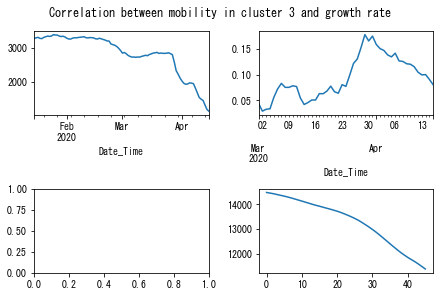

time: 1.04 s


In [115]:
cluster = 3
fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.suptitle("Correlation between mobility in cluster {} and growth rate".format(cluster))
m = mobility_by_cluster.loc[:,cluster]
m.plot(ax=axs[0, 0])
c = daily_confirmed_cases["GrowthRate"]
c.plot(ax=axs[0, 1])
# axs[1,0].plot(c)
axs[1,1].plot(np.convolve(m, c, mode='valid'))
# daily_confirmed_cases

## Looking at time subcomponents
1. Day and night (6am-6pm, 6pm-6am)
- Weekdays and Weekends (+ holidays)

1284 1284


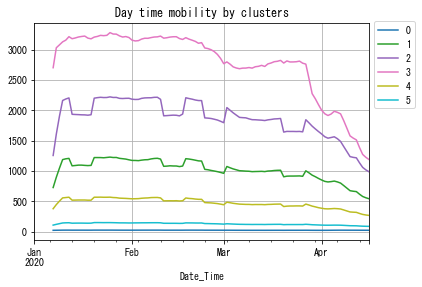

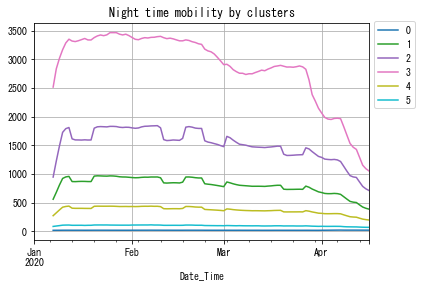

time: 907 ms


In [122]:
# mobility_2020_L1[((mobility_2020_L1.index.hour < 6) or (18 <= mobility_2020_L1.index.hour))]
nighttime = pd.concat([mobility_2020_L1[mobility_2020_L1.index.hour < 6],
                mobility_2020_L1[mobility_2020_L1.index.hour >= 18]])
daytime = mobility_2020_L1[6 <= mobility_2020_L1.index.hour]
daytime = daytime[daytime.index.hour < 18]
print(len(daytime), len(nighttime))

daytime = daytime.T
daytime["cluster"] = pred.astype(int)
daytime_by_cluster = daytime.groupby("cluster").mean().T.reset_index().set_index("Date_Time")
title = "Day time mobility by clusters"
daytime_by_cluster.resample('1D').mean().rolling(7).mean().plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')

nighttime = nighttime.T
nighttime["cluster"] = pred.astype(int)
# print(nighttime)


nighttime_by_cluster = nighttime.groupby("cluster").mean().T.reset_index().set_index("Date_Time")
title = "Night time mobility by clusters"
nighttime_by_cluster.resample('1D').mean().rolling(7).mean().plot(title=title, cmap=cmap, grid=True).legend(bbox_to_anchor=(1, 1.03), loc='upper left')
# nighttime_by_cluster